In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer
from datasets import Dataset
import evaluate

In [2]:
# Downloading latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)

Path to dataset files: /Users/steve/.cache/kagglehub/datasets/ankurzing/sentiment-analysis-for-financial-news/versions/5


In [3]:
# Creating a dataframe to easily view our dataset
df = pd.read_csv(path + '/all-data.csv', header=None, encoding="cp1252")
df.columns = ["Sentiment", "Headline"] 

# Checking out the head of the dataframe
display(df.head())

,Sentiment,Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
# To make our lives easier, we'll start by replacing "negative" and "positive" with numeric values.
df["Sentiment"] = df["Sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Checking out that it worked
display(df.head())

,Sentiment,Headline
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [5]:
# Now we'll split our dataset into test and train sets
train, test = train_test_split(
    df[["Headline", "Sentiment"]],
    test_size=0.2,
    stratify=df["Sentiment"], # Ensuring consistent sentiment proportions across train and test
    random_state=42,
)
len(train), len(test)

(3876, 970)

In [6]:
# Loading the pre-trained BERT tokenizer and model
BERT_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
BERT_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Tokenizing the training and test data for BERT input

# Creating a tokenizing function
def tokenize_function(texts, tokenizer, max_length):
    BERT_output = tokenizer(
        texts.tolist(),
        max_length=max_length,
        truncation=True,
    )
    return BERT_output

In [8]:
# Creating a tokenized dictionary from the training data
train_tokenized = tokenize_function(train["Headline"], BERT_tokenizer, max_length=512)
train_labels = torch.tensor(train["Sentiment"].values)

# Creating a tokenized dictionary from the test data
test_tokenized = tokenize_function(test["Headline"], BERT_tokenizer, max_length=512)
test_labels = torch.tensor(test["Sentiment"].values)

# Adding the labels to the tokenized dictionaries before creating the Dataset objects
train_tokenized['labels'] = train['Sentiment'].tolist()
test_tokenized['labels'] = test['Sentiment'].tolist()

# Converting the tokenized dictionaries to Dataset objects that BERT can use.
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# Creating a data collator for padding purposes
data_collator = DataCollatorWithPadding(tokenizer=BERT_tokenizer)

In [9]:
# Defining a Training Arguments class to contain the hyperparameters the Trainer will use
training_args = TrainingArguments(
    "test-trainer", # directory where the trained model will be saved
    num_train_epochs=5, # increased from 3 to 5 to improve performance
    report_to="none" # Disabling Weights & Biases reporting so no API key is needed.
)

In [10]:
# Defining a Trainer, and passing it all the objects constructed up to now
BERT_trainer = Trainer(
    BERT_model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    processing_class=BERT_tokenizer,
)

In [11]:
# Fine-tuning our model on the dataset with the Trainer
BERT_trainer.train()

/Users/steve/Desktop/USD/AAI 520 - NLP/Group Project/The-Debt-Solver/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.566100
1000,0.307200
1500,0.153800
2000,0.077400


/Users/steve/Desktop/USD/AAI 520 - NLP/Group Project/The-Debt-Solver/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/steve/Desktop/USD/AAI 520 - NLP/Group Project/The-Debt-Solver/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/steve/Desktop/USD/AAI 520 - NLP/Group Project/The-Debt-Solver/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=2425, training_loss=0.2328042008704746, metrics={'train_runtime': 693.4705, 'train_samples_per_second': 27.946, 'train_steps_per_second': 3.497, 'total_flos': 522368523853848.0, 'train_loss': 0.2328042008704746, 'epoch': 5.0})

In [17]:
# Using trainer.predict to run inference on the test dataset
predictions = BERT_trainer.predict(test_dataset)

# Converting the scores from the inference into actual class predictions
predicted_classes = np.argmax(predictions.predictions, axis=-1)

# Evaluating accuracy of predictions
metric_1 = evaluate.load("accuracy")
accuracy = metric_1.compute(
    predictions=predicted_classes, 
    references=predictions.label_ids
)
print(accuracy)

# Evaluating precision of predictions
metric_2 = evaluate.load("precision")
precision = metric_2.compute(
    predictions=predicted_classes,
    references=predictions.label_ids,
    average="macro"
)
print(precision)

# Evaluating recall of predictions
metric_3 = evaluate.load("recall")
recall = metric_3.compute(
    predictions=predicted_classes,
    references=predictions.label_ids,
    average="macro"
)
print(recall)

# Evaluating F1 score of predictions
metric_4 = evaluate.load("f1")
f1 = metric_4.compute(
    predictions=predicted_classes,
    references=predictions.label_ids,
    average="macro"   
)
print(f1)

/Users/steve/Desktop/USD/AAI 520 - NLP/Group Project/The-Debt-Solver/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'accuracy': 0.8494845360824742}
{'precision': 0.829794774546987}
{'recall': 0.8398720387356752}
{'f1': 0.8346907821467303}


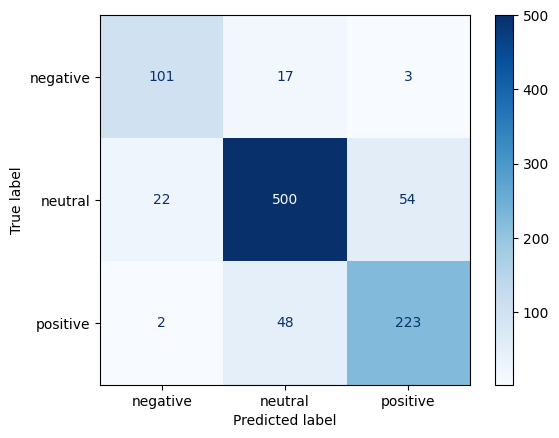

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(predictions.label_ids, predicted_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative","neutral","positive"])
disp.plot(cmap="Blues")
plt.show()

In [19]:
# Trying out a new example to verify

# Creating the world's best review
my_text = "Job numbers for this quarter remain flat"

# sticking it in a dataframe since that's what our pipeline is built for
my_text_df = pd.DataFrame([my_text], columns=["review"])

# Tokenizing it
my_text_tokenized = tokenize_function(my_text_df["review"], BERT_tokenizer, max_length=512)

# Wrapping the tokenized example in a Dataset
my_text_dataset = Dataset.from_dict(my_text_tokenized)

# Using trainer.predict to run inference on the new data
sample_predictions = BERT_trainer.predict(my_text_dataset)

# Converting the scores from the inference into actual class predictions
sample_predicted_class = np.argmax(sample_predictions.predictions, axis=-1)

# Mapping the predicted class back to sentiment, with some embellishment
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
predicted_sentiment = sentiment_map[sample_predicted_class[0]]

# Printing up our final result
print(f"The sentiment of this headline is: {predicted_sentiment}")

/Users/steve/Desktop/USD/AAI 520 - NLP/Group Project/The-Debt-Solver/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


The sentiment of this headline is: Neutral


In [32]:
# Saving the fine-tuned model and the tokenizer for later use
model = BERT_trainer.model
tokenizer = BERT_tokenizer

In [ ]:
# Configuring the model to return human-readable labels when uploaded to HuggingFace

# Mapping labels
labels = {"negative": 0, "neutral": 1, "positive": 2}

# Confuguring the reverse mapping
model.config.id2label = {v: k for k, v in labels.items()}
model.config.label2id = labels

# Setting the problem type for the model
model.config.problem_type = "single_label_classification"

In [33]:
repo_id = "AIGuy1000/news-sentiment-bert-3"

model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/AIGuy1000/news-sentiment-bert-3/commit/7bc6674d932f3b4304200a476cbb1c2e88b36624', commit_message='Upload tokenizer', commit_description='', oid='7bc6674d932f3b4304200a476cbb1c2e88b36624', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AIGuy1000/news-sentiment-bert-3', endpoint='https://huggingface.co', repo_type='model', repo_id='AIGuy1000/news-sentiment-bert-3'), pr_revision=None, pr_num=None)

In [36]:
# Testing the uploaded model

# Selecting the repo
repo_id = "AIGuy1000/news-sentiment-bert-3"
clf = pipeline("text-classification", model=repo_id)

# Printing out some examples
print(clf("The company posted strong quarterly earnings despite headwinds."))
print(clf("The stock outlook remains uncertain due to regulatory risks."))

Device set to use mps:0


[{'label': 'positive', 'score': 0.9995436072349548}]
[{'label': 'neutral', 'score': 0.9947181344032288}]
